In [1]:
import torch

def print_gpu_memory(prefix=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"{prefix} Memory Allocated: {allocated:.2f} MB")
        print(f"{prefix} Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA is not available.")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() 

print_gpu_memory()

 Memory Allocated: 0.00 MB
 Memory Reserved: 0.00 MB


In [2]:
# imports

import os
import sys
sys.path.append(os.path.abspath('..'))

import src.data.preprocess_data as data
import src.training.train_model as train
import src.data.view as view
import src.models.unets as unets
import src.models.hrnets as hrnets

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore


/home/jonathan/UrbanizedAreasSegmentation/.venv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
working_dir = os.path.abspath('..')
models_dir = os.path.join(working_dir, 'models')
models_names = os.listdir(models_dir)

load_model = True
infos = {}
for model_name in models_names:
    print(model_name)
    try:
        patch_size = int(model_name.split('-')[1])
        weighted = 'W.pth' in model_name
        if model_name.split('-')[2]=='type':
            num_classes = 5
        if model_name.split('-')[2]=='binary':
            num_classes = 2
        crf = False
        dist = False
        if len(model_name.split('-'))>=4 and model_name.split('-')[3]=='crf':
            crf = True
        if len(model_name.split('-'))>=4 and model_name.split('-')[3]=='dist':
            dist = True
            
        if load_model:
            if model_name.startswith('UNetSmall-'):
                model = unets.UNetSmall(in_channels=12, out_channels=num_classes, crf=crf, use_dist=dist).to(device) 
            if model_name.startswith('UNet-'):
                model = unets.UNet(in_channels=12, out_channels=num_classes).to(device) 
            elif model_name.startswith('UNetResNet34-'):
                model = unets.UNetResNet34(in_channels=12, out_channels=num_classes).to(device) 
            elif model_name.startswith('UNetEfficientNetB0-'):
                model = unets.UNetEfficientNetB0(in_channels=12, out_channels=num_classes).to(device) 
            elif model_name.startswith('UNetConvNext-'):
                model = unets.UNetConvNext (in_channels=12, out_channels=num_classes).to(device) 
            elif model_name.startswith('HRNetW18'):
                model = hrnets.HRNetSegmentation(in_channels= 12, num_classes=num_classes, backbone="hrnet_w18", pretrained=True,).to(device)
            elif model_name.startswith('HRNetW32'):
                model = hrnets.HRNetSegmentation(in_channels= 12, num_classes=num_classes, backbone="hrnet_w32", pretrained=True,).to(device)
            elif model_name.startswith('HRNetW48'):
                model = hrnets.HRNetSegmentation(in_channels= 12, num_classes=num_classes, backbone="hrnet_w48", pretrained=True,).to(device)
        ckp_file = os.path.join(models_dir, model_name)
        checkpoint = torch.load(ckp_file, weights_only=False)
        info = checkpoint['best_epoch_info']
        infos[model_name] = info
        print(info)
    except Exception as e: 
        print('error loading.')
        print(e)    
        

HRNetW32-512-type-CEW.pth
{'epoch': 17, 'lr': 0.0021999034870767023, 'patience': 2, 'train_loss': 0.8424339730365603, 'train_acc': tensor(0.8665), 'train_micro': np.float64(0.6662771387970237), 'train_macro': np.float64(0.35497134923934937), 'train_weighted': np.float64(0.7680574059486389), 'train_f1_C0': np.float64(0.7656939029693604), 'train_f1_C1': np.float64(0.04988553002476692), 'train_f1_C2': np.float64(0.037475962191820145), 'train_f1_C3': np.float64(0.09831870347261429), 'train_f1_C4': np.float64(0.8234827518463135), 'train_time': 152.1973536014557, 'train_memory': '4247.89 MB', 'train_report':               precision    recall  f1-score    support
Class 0        0.956184  0.638494  0.765694  396405504
Class 1        0.025795  0.755275  0.049886    1828731
Class 2        0.019353  0.589539  0.037476     797902
Class 3        0.052838  0.706044  0.098319    6468036
Class 4        0.914867  0.748697  0.823483  129273792
weighted avg   0.930691  0.666277  0.768057  534773952
macro

In [4]:
import numpy as np

def classification_report_from_cm(cm, class_names=None):
    n_classes = cm.shape[0]
    report = {}
    total_samples = np.sum(cm)
    support = np.sum(cm, axis=1)  # true samples per class
    
    precisions = []
    recalls = []
    f1s = []
    
    for i in range(n_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        # TN is not used for per-class precision/recall/F1
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        
        if class_names:
            label = class_names[i]
        else:
            label = f"Class {i}"
            
        report[label] = {
            "precision": precision,
            "recall": recall,
            "f1-score": f1,
            "support": support[i]
        }
    
    # Optionally, compute weighted averages:
    weighted_precision = np.average(precisions, weights=support)
    weighted_recall = np.average(recalls, weights=support)
    weighted_f1 = np.average(f1s, weights=support)
    
    report["weighted avg"] = {
        "precision": weighted_precision,
        "recall": weighted_recall,
        "f1-score": weighted_f1,
        "support": total_samples
    }
    
    return report

# Example confusion matrix for 3 classes
cm = np.array([[50,  2,  3],
               [ 4, 45,  1],
               [ 5,  2, 40]])

report = classification_report_from_cm(cm, class_names=["A", "B", "C"])
for label, metrics in report.items():
    print(label, metrics)


A {'precision': np.float64(0.847457627118644), 'recall': np.float64(0.9090909090909091), 'f1-score': np.float64(0.8771929824561402), 'support': np.int64(55)}
B {'precision': np.float64(0.9183673469387755), 'recall': np.float64(0.9), 'f1-score': np.float64(0.9090909090909091), 'support': np.int64(50)}
C {'precision': np.float64(0.9090909090909091), 'recall': np.float64(0.851063829787234), 'f1-score': np.float64(0.8791208791208791), 'support': np.int64(47)}
weighted avg {'precision': np.float64(0.8898408524061638), 'recall': np.float64(0.8881578947368421), 'f1-score': np.float64(0.8882818474231216), 'support': np.int64(152)}


In [5]:
infos


{'HRNetW32-512-type-CEW.pth': {'epoch': 17,
  'lr': 0.0021999034870767023,
  'patience': 2,
  'train_loss': 0.8424339730365603,
  'train_acc': tensor(0.8665),
  'train_micro': np.float64(0.6662771387970237),
  'train_macro': np.float64(0.35497134923934937),
  'train_weighted': np.float64(0.7680574059486389),
  'train_f1_C0': np.float64(0.7656939029693604),
  'train_f1_C1': np.float64(0.04988553002476692),
  'train_f1_C2': np.float64(0.037475962191820145),
  'train_f1_C3': np.float64(0.09831870347261429),
  'train_f1_C4': np.float64(0.8234827518463135),
  'train_time': 152.1973536014557,
  'train_memory': '4247.89 MB',
  'train_report':               precision    recall  f1-score    support
  Class 0        0.956184  0.638494  0.765694  396405504
  Class 1        0.025795  0.755275  0.049886    1828731
  Class 2        0.019353  0.589539  0.037476     797902
  Class 3        0.052838  0.706044  0.098319    6468036
  Class 4        0.914867  0.748697  0.823483  129273792
  weighted avg  

['HRNetW18-512-type-CE.pth', 'HRNetW18-512-type-CEW.pth', 'HRNetW32-512-type-CE.pth', 'HRNetW32-512-type-CEW.pth', 'HRNetW48-512-type-CE.pth', 'HRNetW48-512-type-CEW.pth', 'UNet-256-type-CE.pth', 'UNet-256-type-CEW.pth', 'UNet-64-type-CE.pth', 'UNet-64-type-CEW.pth', 'UNetConvNext-224-type-CE.pth', 'UNetConvNext-224-type-CEW.pth', 'UNetConvNext-224-type-groups.pth', 'UNetConvNext-224-type-groupsW.pth', 'UNetEfficientNetB0-224-type-CE.pth', 'UNetEfficientNetB0-224-type-CEW.pth', 'UNetEfficientNetB0-224-type-groups.pth', 'UNetEfficientNetB0-224-type-groupsW.pth', 'UNetResNet34-224-type-CE.pth', 'UNetResNet34-224-type-CEW.pth', 'UNetResNet34-224-type-groups.pth', 'UNetResNet34-224-type-groupsW.pth', 'UNetSmall-256-type-CE-diceW.pth', 'UNetSmall-256-type-CE.pth', 'UNetSmall-256-type-CEW.pth', 'UNetSmall-256-type-crf-CE.pth', 'UNetSmall-256-type-crf-CEW.pth', 'UNetSmall-256-type-crf-groups.pth', 'UNetSmall-256-type-crf-groupsW.pth', 'UNetSmall-256-type-diceW.pth', 'UNetSmall-256-type-dist-C

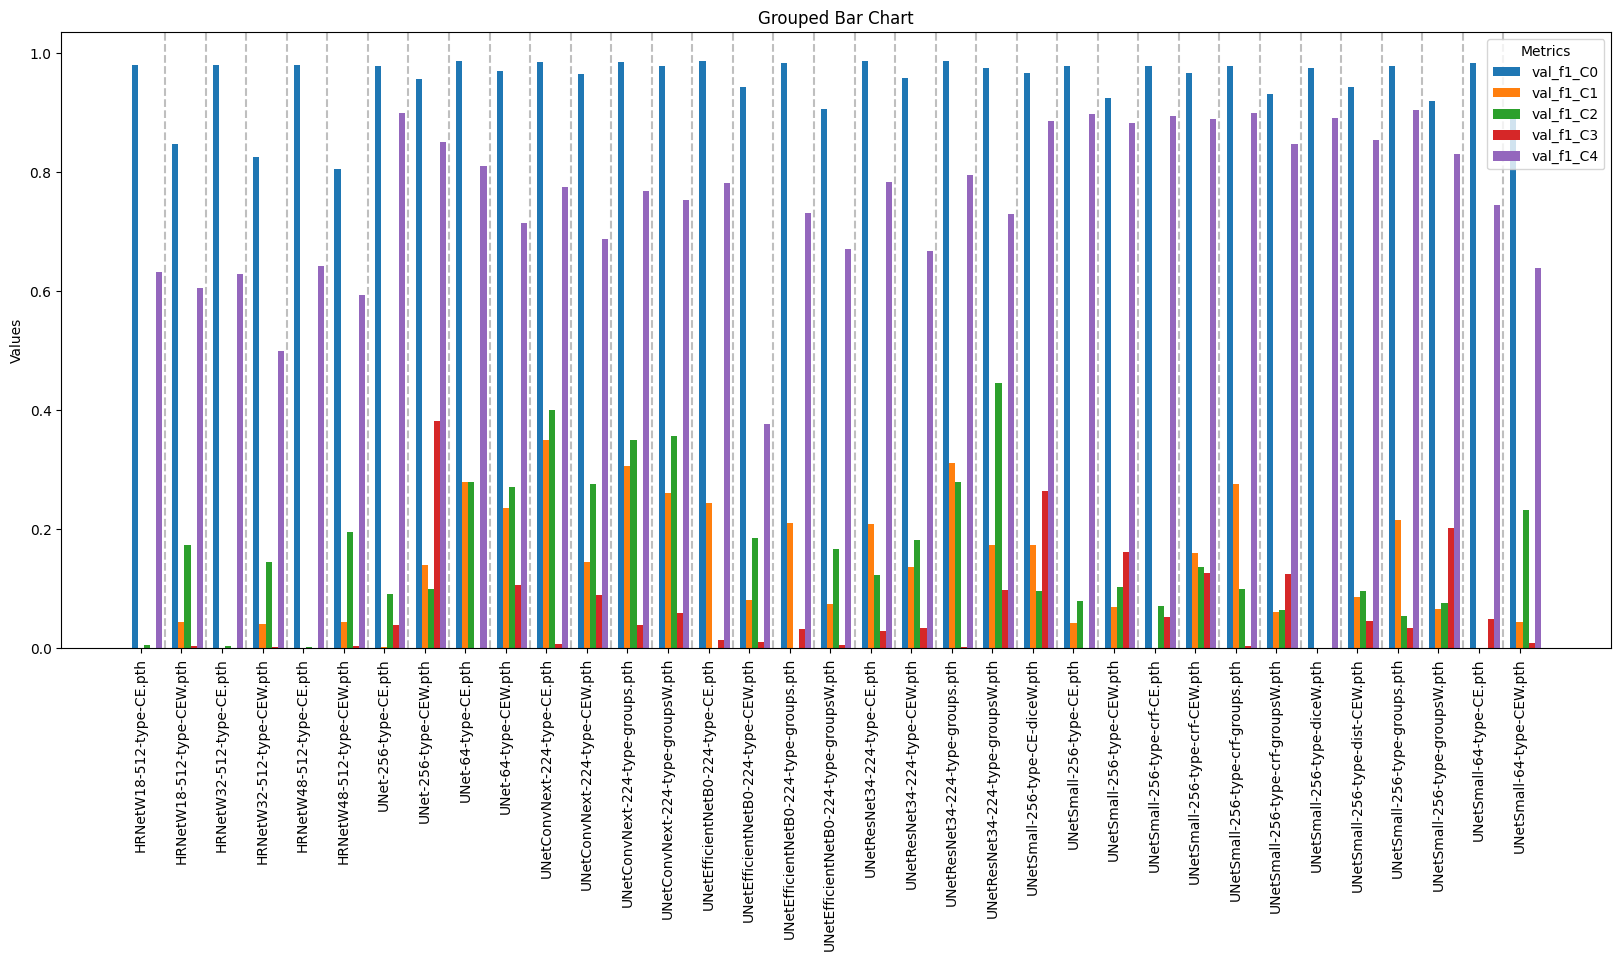

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

infos = dict(sorted(infos.items()))



keys = ["val_f1_C0", "val_f1_C1", "val_f1_C2", "val_f1_C3", "val_f1_C4"]

names = list(infos.keys())  # X-axis labels
print(names)
values = [[infos[name][k] for k in keys] for name in names]  # Data for each group

# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

# Plot bars for each key
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in values], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


plt.show()


/tmp/ipykernel_96365/2783429682.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=90)


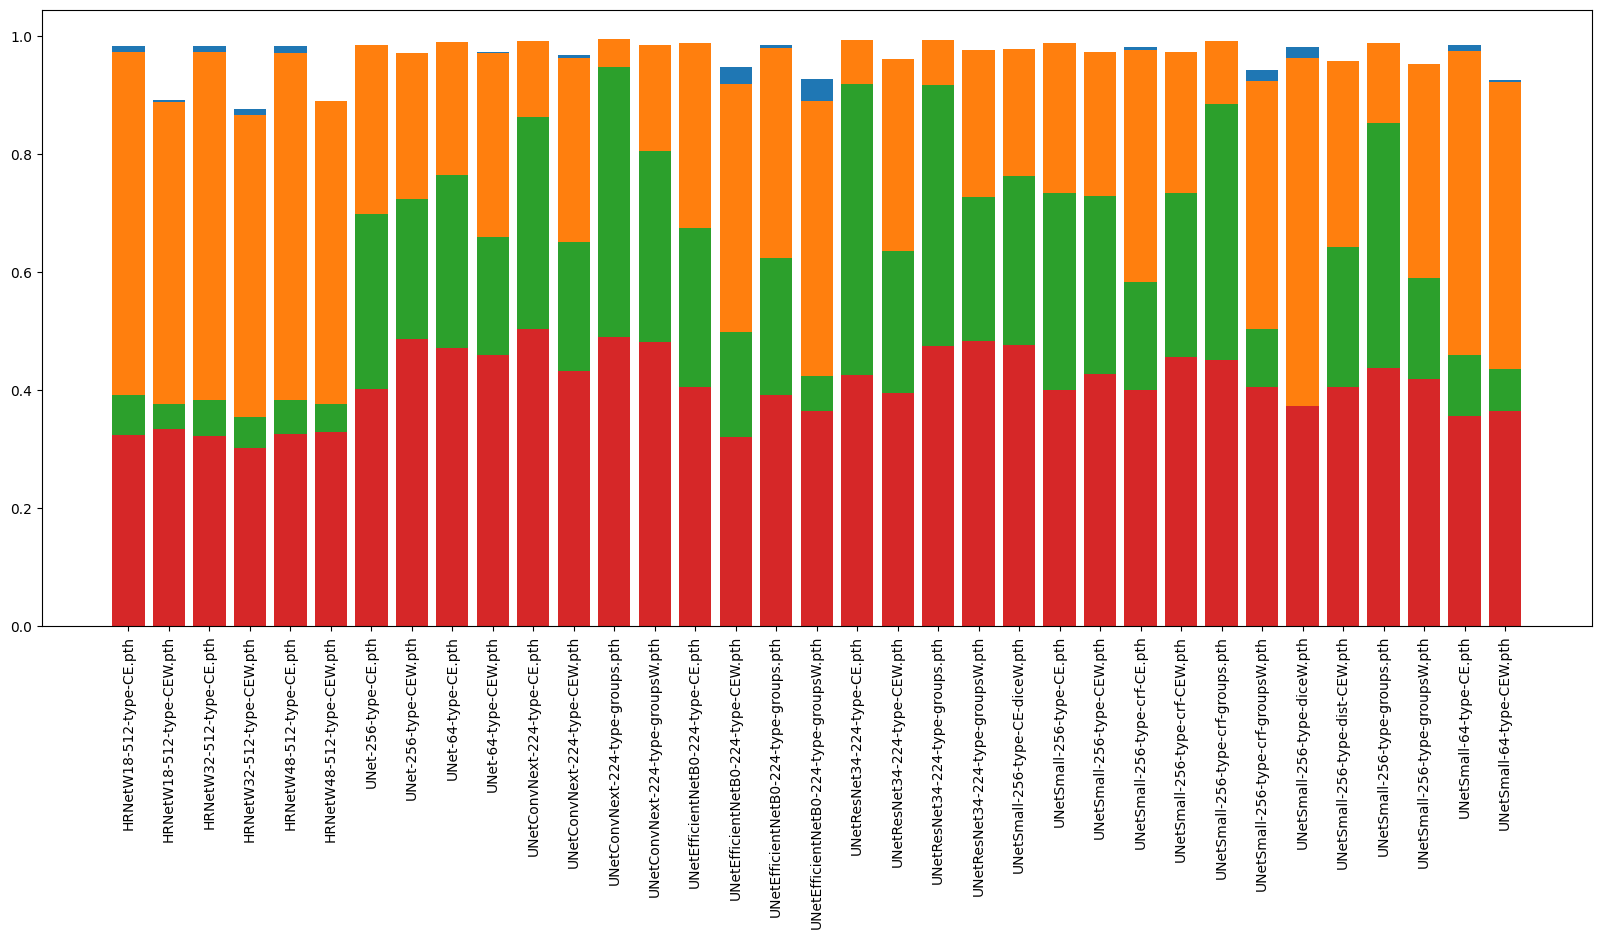

['HRNetW18-512-type-CE.pth', 'HRNetW18-512-type-CEW.pth', 'HRNetW32-512-type-CE.pth', 'HRNetW32-512-type-CEW.pth', 'HRNetW48-512-type-CE.pth', 'HRNetW48-512-type-CEW.pth', 'UNet-256-type-CE.pth', 'UNet-256-type-CEW.pth', 'UNet-64-type-CE.pth', 'UNet-64-type-CEW.pth', 'UNetConvNext-224-type-CE.pth', 'UNetConvNext-224-type-CEW.pth', 'UNetConvNext-224-type-groups.pth', 'UNetConvNext-224-type-groupsW.pth', 'UNetEfficientNetB0-224-type-CE.pth', 'UNetEfficientNetB0-224-type-CEW.pth', 'UNetEfficientNetB0-224-type-groups.pth', 'UNetEfficientNetB0-224-type-groupsW.pth', 'UNetResNet34-224-type-CE.pth', 'UNetResNet34-224-type-CEW.pth', 'UNetResNet34-224-type-groups.pth', 'UNetResNet34-224-type-groupsW.pth', 'UNetSmall-256-type-CE-diceW.pth', 'UNetSmall-256-type-CE.pth', 'UNetSmall-256-type-CEW.pth', 'UNetSmall-256-type-crf-CE.pth', 'UNetSmall-256-type-crf-CEW.pth', 'UNetSmall-256-type-crf-groups.pth', 'UNetSmall-256-type-crf-groupsW.pth', 'UNetSmall-256-type-diceW.pth', 'UNetSmall-256-type-dist-C

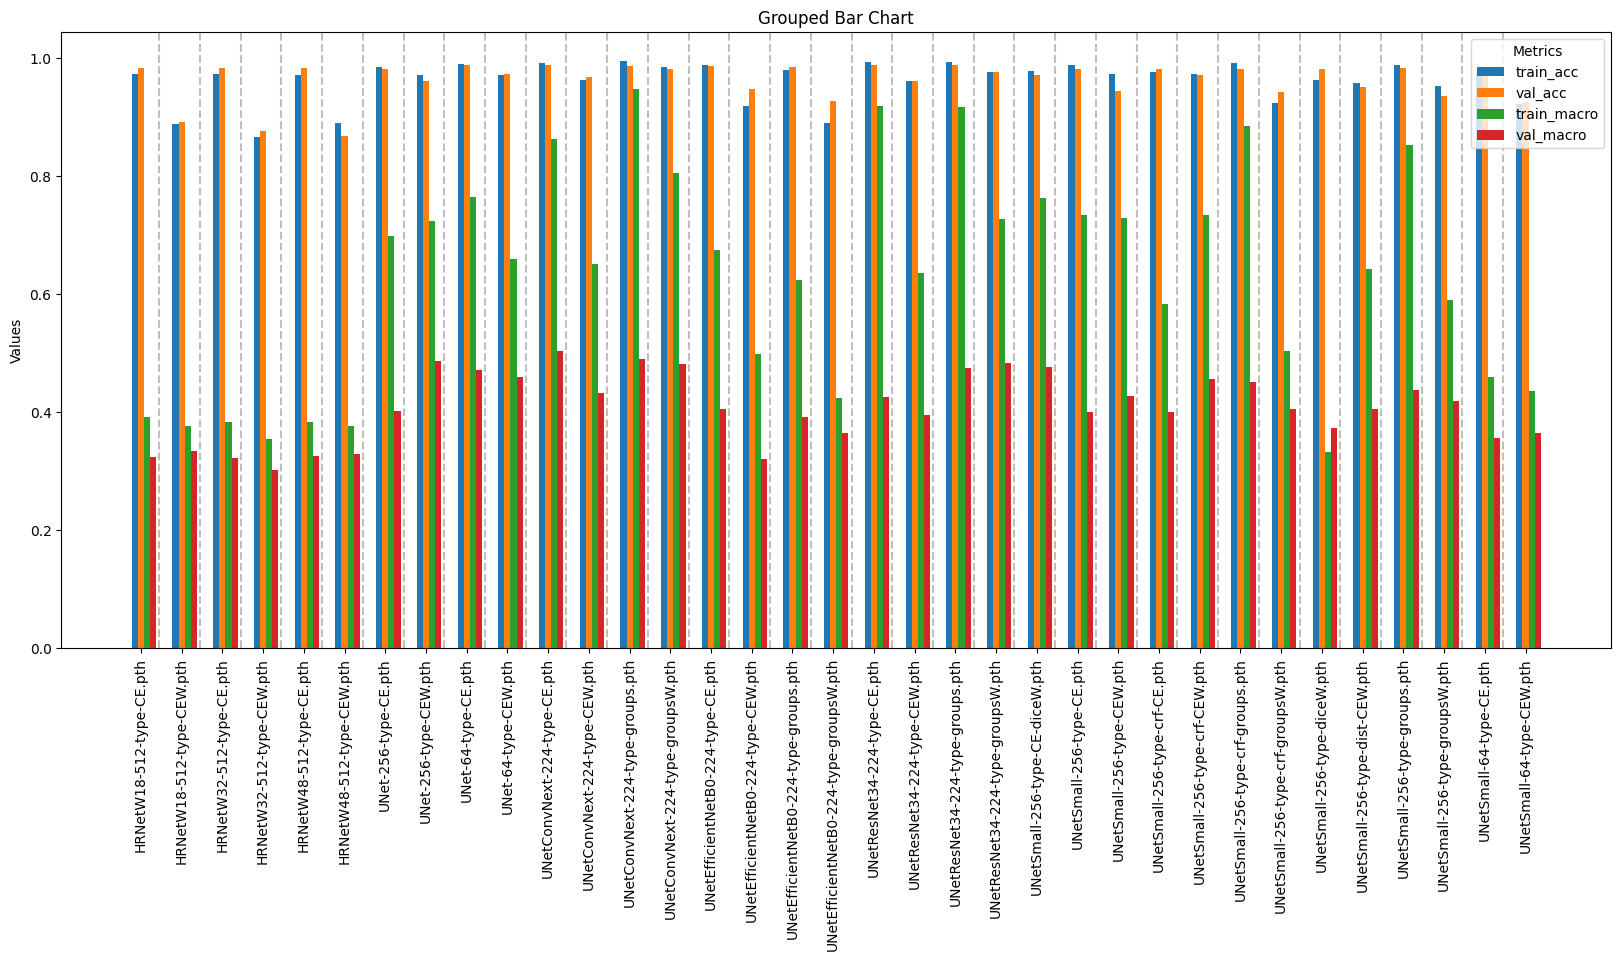

In [27]:

import matplotlib.pyplot as plt
import numpy as np

infos = dict(sorted(infos.items()))



keys = ["val_f1_C0", "val_f1_C1", "val_f1_C2", "val_f1_C3", "val_f1_C4"]
keys = ["train_acc", "val_acc", "train_macro", "val_macro"]

names = list(infos.keys())  # X-axis labels
train_acc = [infos[name]['train_acc'] for name in names]
val_acc = [infos[name]['val_acc'] for name in names]
train_macro = [infos[name]['train_macro'] for name in names]
val_macro = [infos[name]['val_macro'] for name in names]

fig, ax = plt.subplots(figsize=(20, 8)) 

ax.bar(names, val_acc)
ax.bar(names, train_acc)
ax.bar(names, train_macro)
ax.bar(names, val_macro)
ax.set_xticklabels(names, rotation=90)
plt.show()
print(names)
values = [[infos[name][k] for k in keys] for name in names]  # Data for each group

print(values)
# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

# Plot bars for each key
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in values], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


plt.show()


['HRNetW18-512-type-CE.pth', 'HRNetW18-512-type-CEW.pth', 'HRNetW32-512-type-CE.pth', 'HRNetW32-512-type-CEW.pth', 'HRNetW48-512-type-CE.pth', 'HRNetW48-512-type-CEW.pth', 'UNet-256-type-CE.pth', 'UNet-256-type-CEW.pth', 'UNet-64-type-CE.pth', 'UNet-64-type-CEW.pth', 'UNetConvNext-224-type-CE.pth', 'UNetConvNext-224-type-CEW.pth', 'UNetConvNext-224-type-groups.pth', 'UNetConvNext-224-type-groupsW.pth', 'UNetEfficientNetB0-224-type-CE.pth', 'UNetEfficientNetB0-224-type-CEW.pth', 'UNetEfficientNetB0-224-type-groups.pth', 'UNetEfficientNetB0-224-type-groupsW.pth', 'UNetResNet34-224-type-CE.pth', 'UNetResNet34-224-type-CEW.pth', 'UNetResNet34-224-type-groups.pth', 'UNetResNet34-224-type-groupsW.pth', 'UNetSmall-256-type-CE-diceW.pth', 'UNetSmall-256-type-CE.pth', 'UNetSmall-256-type-CEW.pth', 'UNetSmall-256-type-crf-CE.pth', 'UNetSmall-256-type-crf-CEW.pth', 'UNetSmall-256-type-crf-groups.pth', 'UNetSmall-256-type-crf-groupsW.pth', 'UNetSmall-256-type-diceW.pth', 'UNetSmall-256-type-dist-C

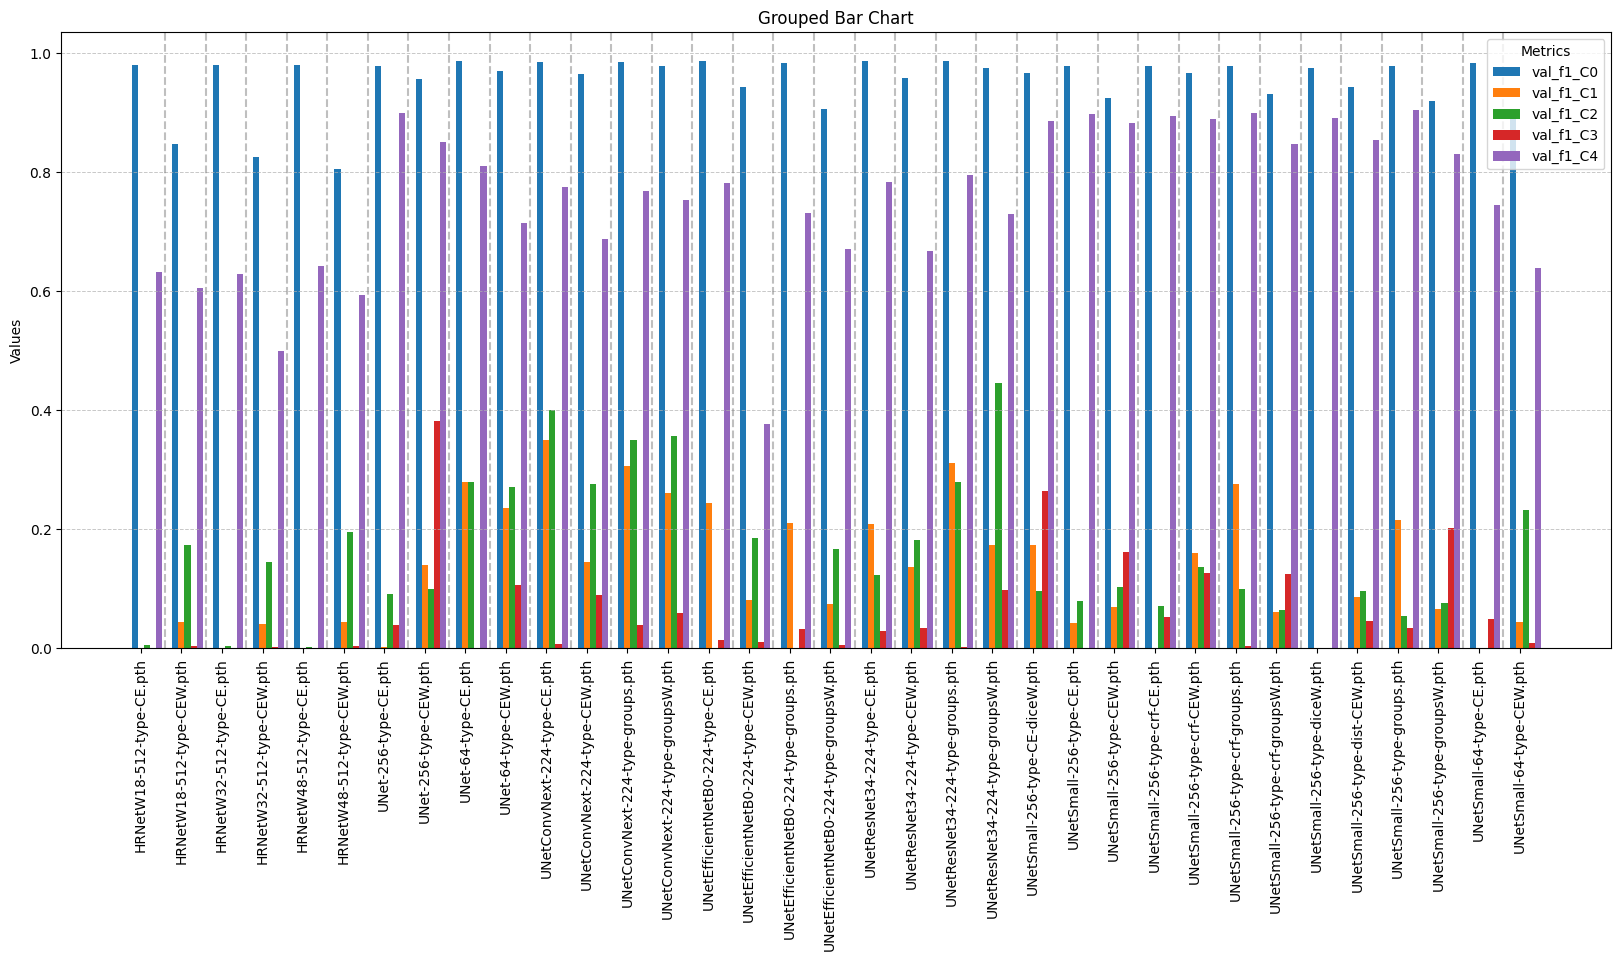

In [7]:

import matplotlib.pyplot as plt
import numpy as np

infos = dict(sorted(infos.items()))



keys = ["val_f1_C0", "val_f1_C1", "val_f1_C2", "val_f1_C3", "val_f1_C4"]

names = list(infos.keys())  # X-axis labels
print(names)
values = [[infos[name][k] for k in keys] for name in names]  # Data for each group

# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

# Plot bars for each key
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in values], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


plt.show()


In [8]:
#info['val_report']['precision']
#info['val_report']['recall']
precisions = []
recalls = []
precisions_train = []
recalls_train = []

#values = [[infos[name][k] for k in keys] for name in names]  # Data for each group

for k,v in infos.items():
    print(k)
    prec=[]
    rec = []
    prec_t=[]
    rec_t = []
    for i in range(5):
        prec.append(v['val_report']['precision'][f'Class {i}'])
        rec.append(v['val_report']['recall'][f'Class {i}'])
        prec_t.append(v['train_report']['precision'][f'Class {i}'])
        rec_t.append(v['train_report']['recall'][f'Class {i}'])
        #print(v['val_report']['precision'][f'Class {i}'])
        #print(v['val_report']['recall'][f'Class {i}'])
    precisions.append(prec)
    recalls.append(rec)
    precisions_train.append(prec_t)
    recalls_train.append(rec_t)


HRNetW18-512-type-CE.pth
HRNetW18-512-type-CEW.pth
HRNetW32-512-type-CE.pth
HRNetW32-512-type-CEW.pth
HRNetW48-512-type-CE.pth
HRNetW48-512-type-CEW.pth
UNet-256-type-CE.pth
UNet-256-type-CEW.pth
UNet-64-type-CE.pth
UNet-64-type-CEW.pth
UNetConvNext-224-type-CE.pth
UNetConvNext-224-type-CEW.pth
UNetConvNext-224-type-groups.pth
UNetConvNext-224-type-groupsW.pth
UNetEfficientNetB0-224-type-CE.pth
UNetEfficientNetB0-224-type-CEW.pth
UNetEfficientNetB0-224-type-groups.pth
UNetEfficientNetB0-224-type-groupsW.pth
UNetResNet34-224-type-CE.pth
UNetResNet34-224-type-CEW.pth
UNetResNet34-224-type-groups.pth
UNetResNet34-224-type-groupsW.pth
UNetSmall-256-type-CE-diceW.pth
UNetSmall-256-type-CE.pth
UNetSmall-256-type-CEW.pth
UNetSmall-256-type-crf-CE.pth
UNetSmall-256-type-crf-CEW.pth
UNetSmall-256-type-crf-groups.pth
UNetSmall-256-type-crf-groupsW.pth
UNetSmall-256-type-diceW.pth
UNetSmall-256-type-dist-CEW.pth
UNetSmall-256-type-groups.pth
UNetSmall-256-type-groupsW.pth
UNetSmall-64-type-CE.pth

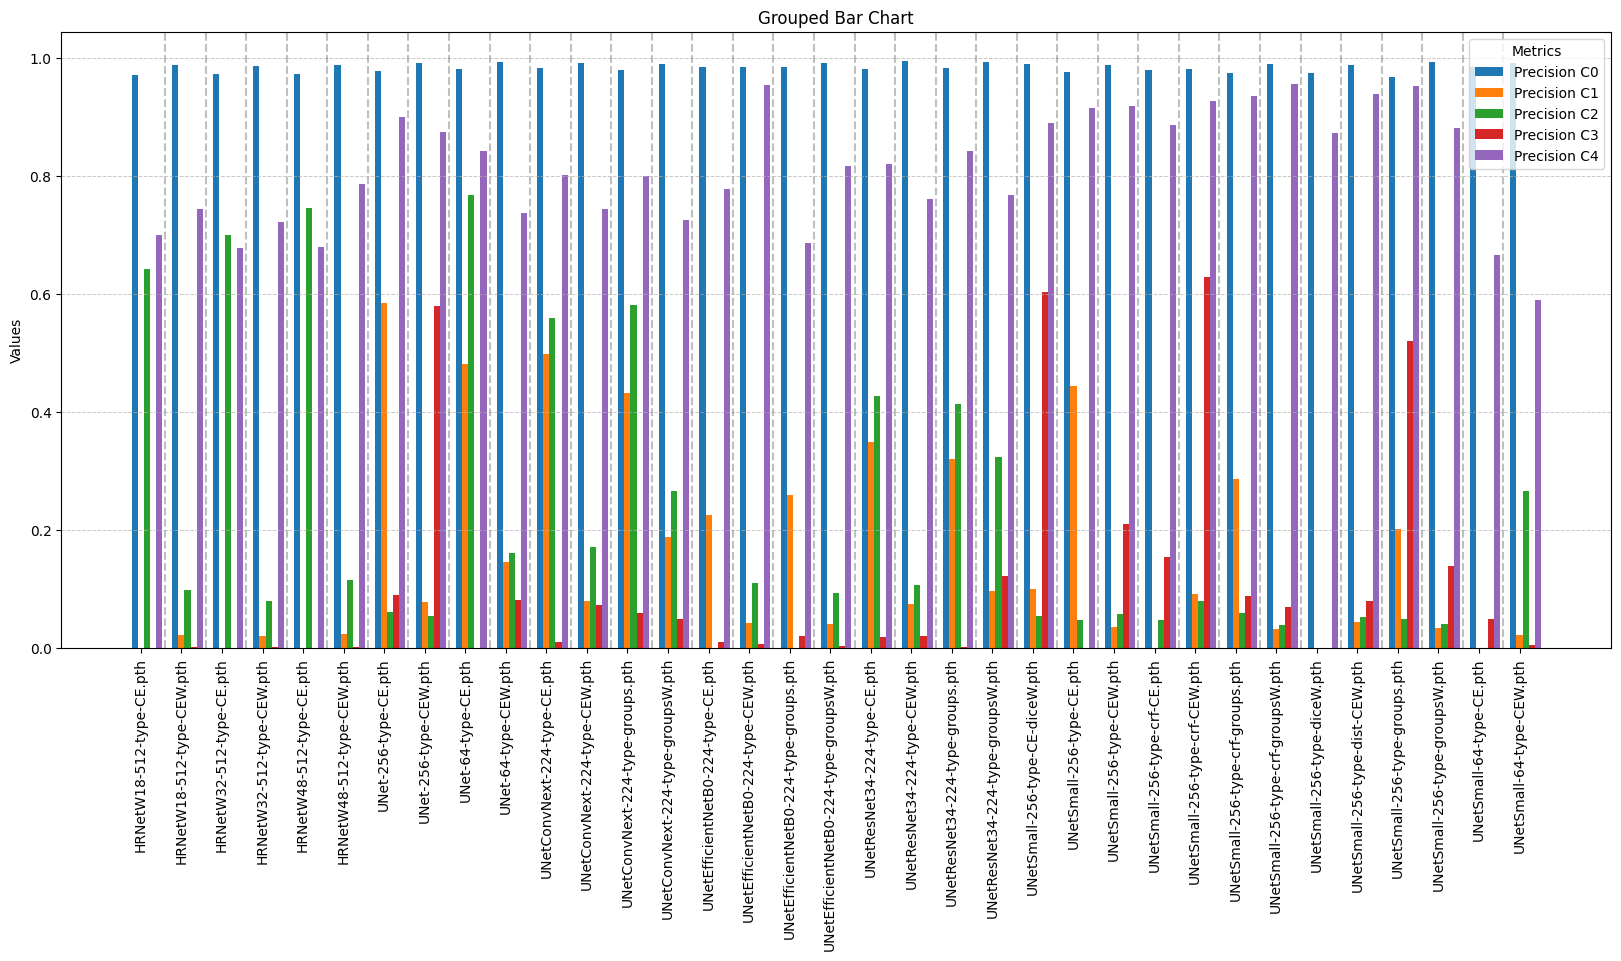

In [9]:

# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

# Plot bars for each key
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
keys = ['Precision C0', 'Precision C1', 'Precision C2','Precision C3','Precision C4']
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in precisions], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)
#ax.grid(axis="y", which="minor", linestyle=":", linewidth=0.5)  # Dotted minor grid

ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


plt.show()

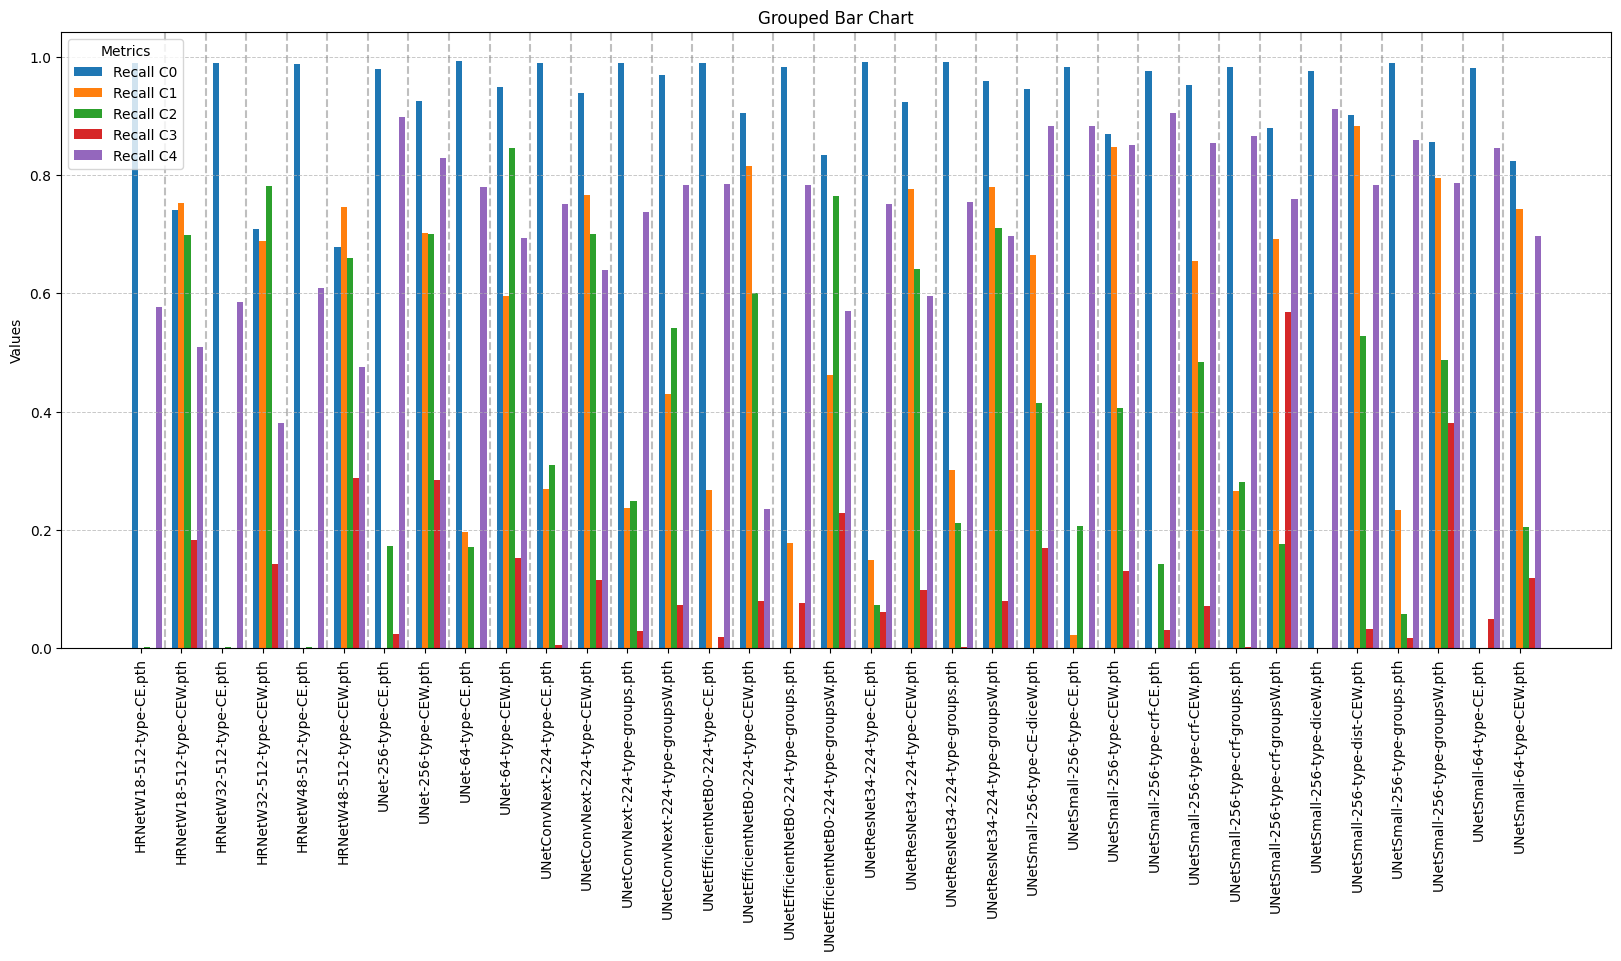

In [10]:

# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

keys = ['Recall C0', 'Recall C1', 'Recall C2','Recall C3','Recall C4']

# Plot bars for each key
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in recalls], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


plt.show()

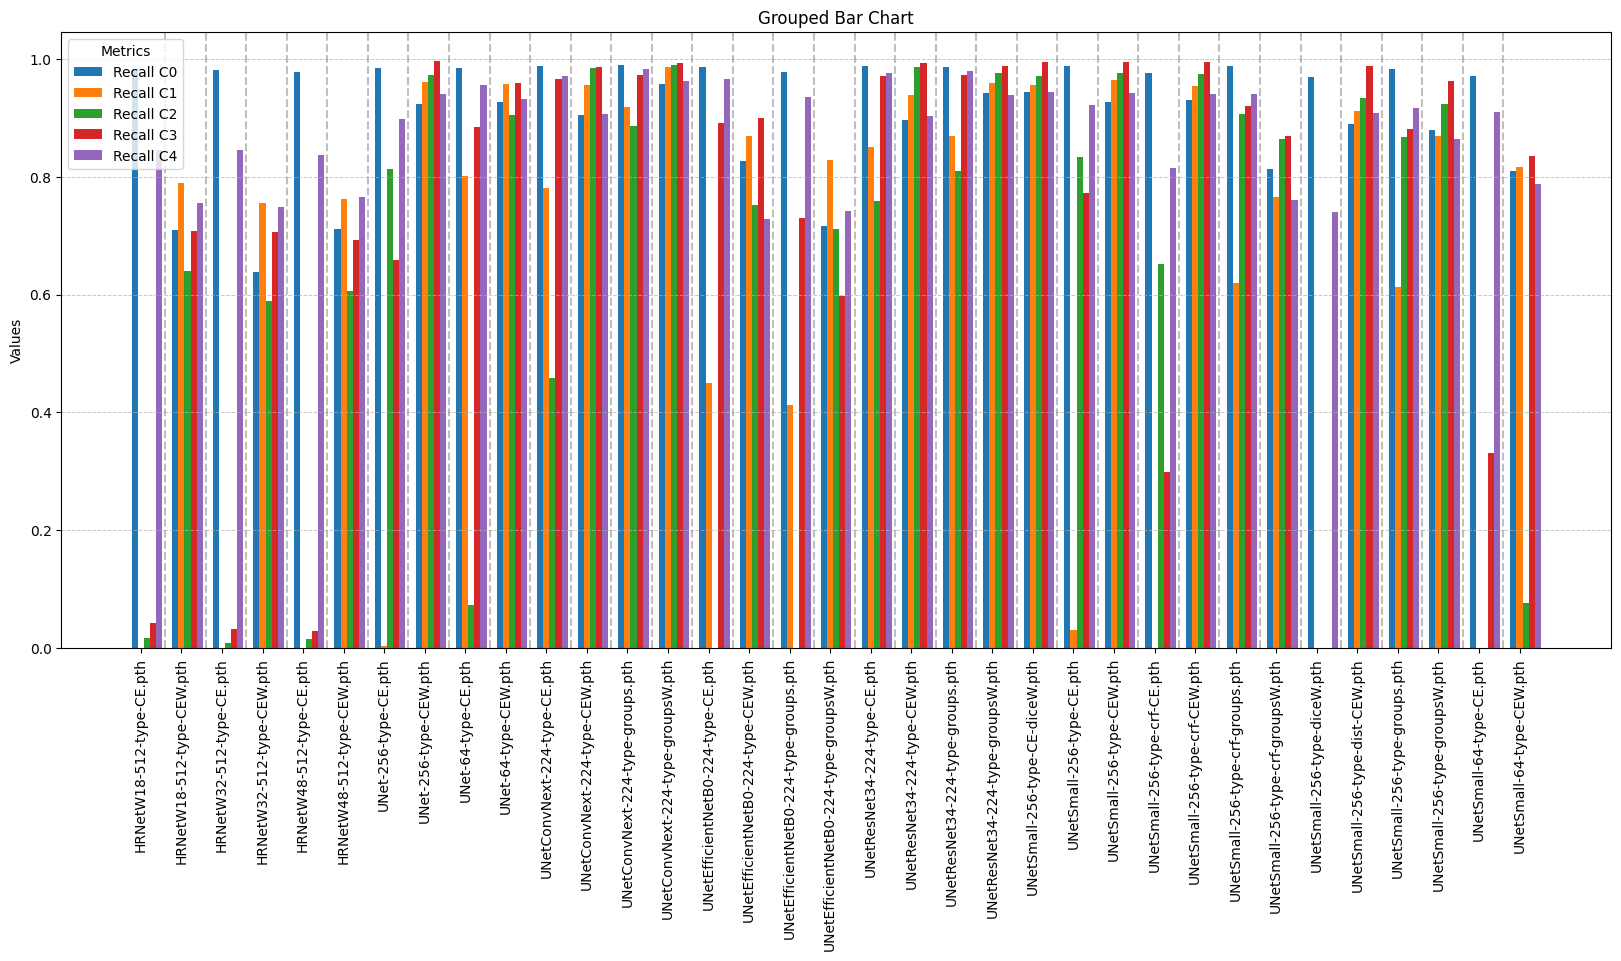

In [11]:

# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

keys = ['Recall C0', 'Recall C1', 'Recall C2','Recall C3','Recall C4']

# Plot bars for each key
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in recalls_train], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


plt.show()

['HRNetW18-512-type-CE.pth', 'HRNetW18-512-type-CEW.pth', 'HRNetW32-512-type-CE.pth', 'HRNetW32-512-type-CEW.pth', 'HRNetW48-512-type-CE.pth', 'HRNetW48-512-type-CEW.pth', 'UNet-256-type-CE.pth', 'UNet-256-type-CEW.pth', 'UNet-64-type-CE.pth', 'UNet-64-type-CEW.pth', 'UNetConvNext-224-type-CE.pth', 'UNetConvNext-224-type-CEW.pth', 'UNetConvNext-224-type-groups.pth', 'UNetConvNext-224-type-groupsW.pth', 'UNetEfficientNetB0-224-type-CE.pth', 'UNetEfficientNetB0-224-type-CEW.pth', 'UNetEfficientNetB0-224-type-groups.pth', 'UNetEfficientNetB0-224-type-groupsW.pth', 'UNetResNet34-224-type-CE.pth', 'UNetResNet34-224-type-CEW.pth', 'UNetResNet34-224-type-groups.pth', 'UNetResNet34-224-type-groupsW.pth', 'UNetSmall-256-type-CE-diceW.pth', 'UNetSmall-256-type-CE.pth', 'UNetSmall-256-type-CEW.pth', 'UNetSmall-256-type-crf-CE.pth', 'UNetSmall-256-type-crf-CEW.pth', 'UNetSmall-256-type-crf-groups.pth', 'UNetSmall-256-type-crf-groupsW.pth', 'UNetSmall-256-type-diceW.pth', 'UNetSmall-256-type-dist-C

Text(0.5, 1.0, 'Grouped Bar Chart')

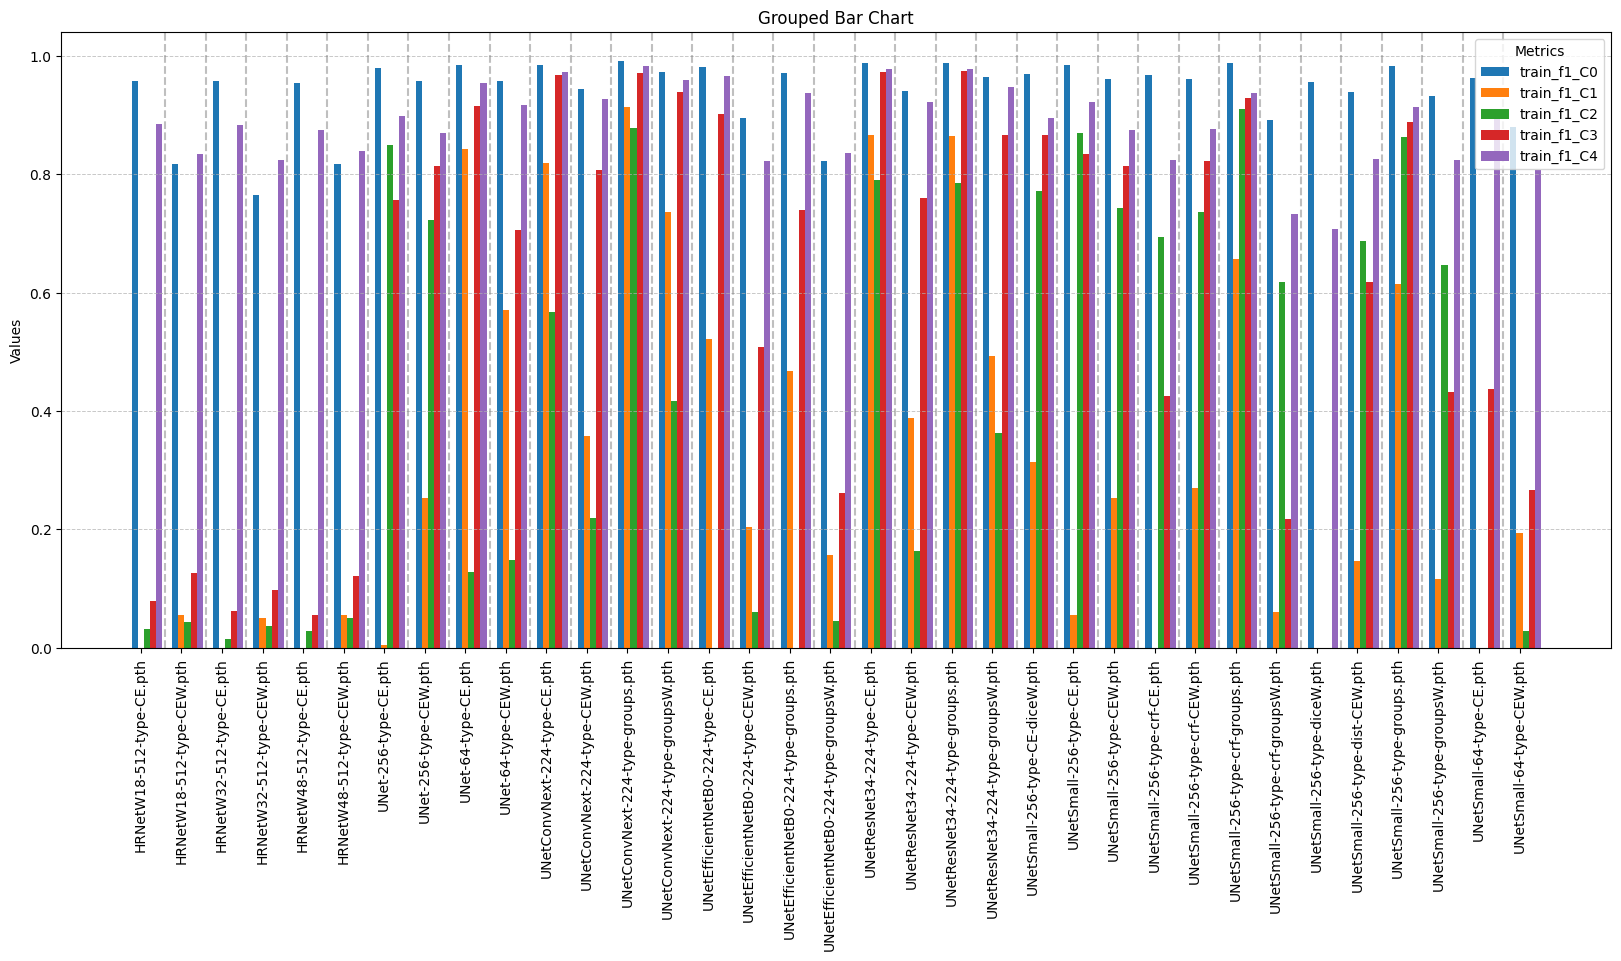

In [12]:
import matplotlib.pyplot as plt
import numpy as np

infos = dict(sorted(infos.items()))



keys = ["train_f1_C0", "train_f1_C1", "train_f1_C2", "train_f1_C3", "train_f1_C4"]

names = list(infos.keys())  # X-axis labels
print(names)
values = [[infos[name][k] for k in keys] for name in names]  # Data for each group

# Bar chart settings
x = np.arange(len(names))  # Positions for groups
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(20, 8)) 

# Plot bars for each key
for i, key in enumerate(keys):
    ax.bar(x + i * width, [v[i] for v in values], width, label=key)
for pos in x[:-1]:  # Avoid last position
    ax.axvline(pos + width * len(keys), color="gray", linestyle="--", alpha=0.5)
# Format plot
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.7)

ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(names, rotation=90)
ax.legend(title="Metrics")
ax.set_ylabel("Values")
ax.set_title("Grouped Bar Chart")
#ax.set_xticklabels(ax.get_xticks(), rotation=45)  # Rotate labels by 45 degrees


In [13]:
Classes:
0 -> fundo
1 -> loteamento vazio
2 -> outros equipamentos
3 -> vazio intraurbano
4 -> area urbanizada

LR dos HRNet muito baixo? mais epocas/paciencia?

weighted: ajudou na classe 3


SyntaxError: invalid syntax (4198848057.py, line 1)